## 1. Mục tiêu và Phạm vi Phân tích (Objectives & Scope)

**Mục tiêu chính:**
Xây dựng và so sánh hiệu suất của các mô hình Machine Learning (Học máy) nhằm dự báo giá đóng cửa (**Close Price**) của tiền mã hóa (cụ thể là cặp **BTCUSDT**) cho khung giờ tiếp theo.

**Bài toán:**
Đây là bài toán **Hồi quy (Regression)** trên dữ liệu chuỗi thời gian (Time-series).

**Các mô hình được sử dụng để kiểm thử (Benchmark):**
1.  **Linear Regression:** Mô hình cơ sở (Baseline) để kiểm tra các mối quan hệ tuyến tính đơn giản.
2.  **Random Forest Regressor:** Mô hình phi tuyến tính dựa trên kết hợp nhiều cây quyết định (Bagging).
3.  **Gradient Boosting Regressor:** Mô hình Boosting cơ bản của Scikit-learn.
4.  **XGBoost (Extreme Gradient Boosting):** Mô hình tối ưu hóa tốc độ và hiệu suất, thường đạt kết quả cao trong các bài toán dữ liệu bảng.

In [10]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Các thư viện Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


## 2. Quy trình Thực hiện (Methodology)


1.  **Thu thập & Làm sạch dữ liệu (Data Cleaning):**
    * Xử lý dữ liệu thô, chuyển đổi định dạng thời gian (`timestamp`).
    * Lọc dữ liệu để đảm bảo tính nhất quán (chỉ giữ lại cặp `BTCUSDT` để tránh nhiễu do trộn lẫn nhiều coin).
    * Xử lý các giá trị bị thiếu (Missing values) nếu có.

2.  **Tạo đặc trưng (Feature Engineering):**
    * Tạo biến mục tiêu (`Target`): Giá Close của giờ tiếp theo (`shift(-1)`).
    * Tạo biến độ trễ (`Lag Features`): Giá của 1h, 2h trước đó để nắm bắt xu hướng gần.
    * Tạo chỉ báo kỹ thuật: Đường trung bình trượt (`MA_24`), độ biến động (`Volatility`), tỷ lệ mua chủ động (`Taker Buy Ratio`).

3.  **Chia tập dữ liệu (Data Splitting):**
    * Sử dụng phương pháp chia theo thời gian (**Time-based split**): 80% dữ liệu đầu làm tập huấn luyện (Train), 20% dữ liệu sau làm tập kiểm thử (Test).
    * *Lưu ý:* Không sử dụng `shuffle=True` để tránh lỗi nhìn trước tương lai (Look-ahead bias).

4.  **Huấn luyện & Đánh giá (Modeling & Evaluation):**
    * Huấn luyện các mô hình trên tập Train.
    * Đánh giá trên tập Test bằng hai chỉ số:
        * **RMSE (Root Mean Squared Error):** Đo lường sai số trung bình (đơn vị USDT). Càng thấp càng tốt.
        * **R² Score:** Đo lường mức độ giải thích biến thiên của mô hình (từ 0 đến 1). Càng cao càng tốt.

In [ ]:

df = pd.read_csv('../Data/processed/fully_processed_data.csv')
if 'timestamp' in df.columns:
    if pd.api.types.is_numeric_dtype(df['timestamp']):
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    else:
        df['datetime'] = pd.to_datetime(df['timestamp'])

elif 'date' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'])

df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

print("Đã fix lỗi và chuyển đổi thời gian thành công!")
df.head()

Đã fix lỗi và chuyển đổi thời gian thành công!


,open,high,low,close,volume,quote_volume,trades_count,taker_buy_base_volume,taker_buy_quote_volume,timestamp,date,time,symbol,interval
datetime,,,,,,,,,,,,,,
2025-10-23 20:00:00,110200.0100,110200.0100,109341.2800,109524.8100,6.292085e+02,6.913393e+07,149610.0,2.459674e+02,2.702773e+07,2025-10-23 20:00:00,2025-10-23,20:00:00,BTCUSDT,1h
2025-10-23 20:00:00,1117.8100,1118.2800,1111.0400,1113.7300,1.111467e+04,1.239589e+07,66132.0,4.778755e+03,5.330665e+06,2025-10-23 20:00:00,2025-10-23,20:00:00,BNBUSDT,1h
2025-10-23 20:00:00,483.5000,483.5000,477.9000,479.5000,1.012639e+03,4.873283e+05,1813.0,3.607340e+02,1.735721e+05,2025-10-23 20:00:00,2025-10-23,20:00:00,BCHUSDT,1h
2025-10-23 20:00:00,385.9000,386.2000,379.6000,380.9000,3.196205e+03,1.224617e+06,5991.0,1.441140e+03,5.523856e+05,2025-10-23 20:00:00,2025-10-23,20:00:00,TAOUSDT,1h
2025-10-23 20:00:00,0.9996,0.9996,0.9995,0.9995,2.205109e+07,2.204125e+07,13289.0,1.184165e+07,1.183691e+07,2025-10-23 20:00:00,2025-10-23,20:00:00,USDCUSDT,1h


In [ ]:

if 'symbol' in df.columns:
    print("Các cặp coin có trong dữ liệu:", df['symbol'].unique())
    target_symbol = 'ETHUSDT' 
    df = df[df['symbol'] == target_symbol].copy()
    
    print(f"-> Đã lọc dữ liệu, chỉ giữ lại: {target_symbol}")
    print(f"Kích thước dữ liệu sau khi lọc: {df.shape}")
else:
    print("Cảnh báo: Không tìm thấy cột 'symbol'. Hãy kiểm tra lại dữ liệu!")
df.sort_index(inplace=True)

Các cặp coin có trong dữ liệu: ['BTCUSDT' 'BNBUSDT' 'BCHUSDT' 'TAOUSDT' 'USDCUSDT' 'PEPEUSDT' 'ASTERUSDT'
 'AVAXUSDT' 'HBARUSDT' 'PAXGUSDT' 'ADAUSDT' 'ETHUSDT' 'XPLUSDT' 'NEARUSDT'
 'ZECUSDT' 'XRPUSDT' 'LTCUSDT' 'FDUSDUSDT' 'BFUSDUSDT' 'DOGEUSDT'
 'ENAUSDT' 'LINKUSDT' 'TRXUSDT' 'VIRTUALUSDT' 'UNIUSDT' 'SUIUSDT'
 'SOLUSDT' 'GIGGLEUSDT' 'SAPIENUSDT' 'ATUSDT']
-> Đã lọc dữ liệu, chỉ giữ lại: ETHUSDT
Kích thước dữ liệu sau khi lọc: (1000, 14)


In [ ]:

df['close_lag1'] = df['close'].shift(1)
df['close_lag2'] = df['close'].shift(2)

df['MA_24'] = df['close'].rolling(window=24).mean()

df['volatility'] = df['high'] - df['low']

df['taker_buy_ratio'] = df['taker_buy_base_volume'] / (df['volume'] + 1e-9)

df['Target'] = df['close'].shift(-1)

df.dropna(inplace=True)

print(f"Dữ liệu sau khi xử lý: {df.shape}")
df[['close', 'Target', 'MA_24']].head()

Dữ liệu sau khi xử lý: (976, 20)


,close,Target,MA_24
datetime,,,
2025-10-24 19:00:00,3926.53,3938.77,3912.905000
2025-10-24 20:00:00,3938.77,3943.71,3917.470417
2025-10-24 21:00:00,3943.71,3935.88,3922.253750
2025-10-24 22:00:00,3935.88,3934.88,3925.792083
2025-10-24 23:00:00,3934.88,3918.40,3929.045417


Train size: (780, 7)
Test size: (196, 7)


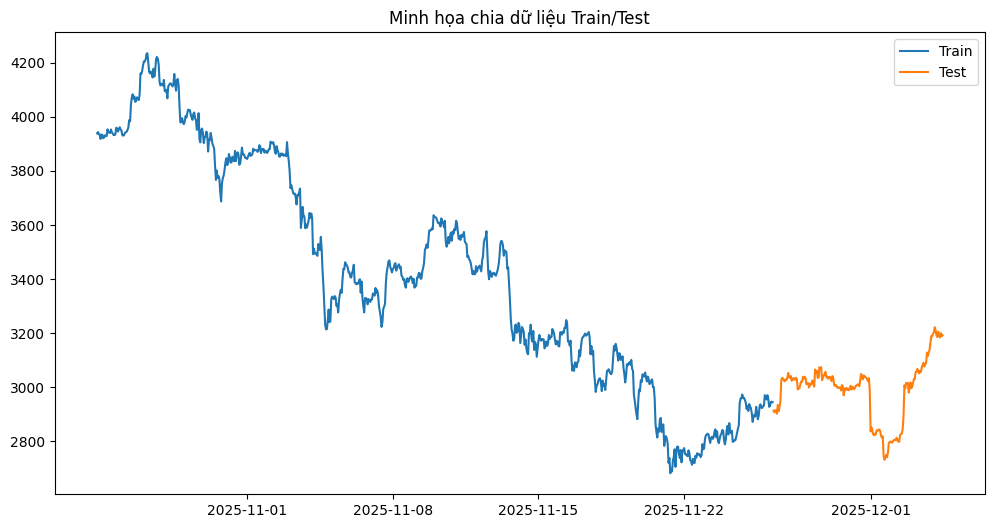

In [ ]:

features = ['close_lag1', 'close_lag2', 'MA_24', 'volatility', 'taker_buy_ratio', 'volume', 'trades_count']
target = 'Target'

X = df[features]
y = df[target]

split_point = int(len(df) * 0.8)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]

y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.title('Minh họa chia dữ liệu Train/Test')
plt.legend()
plt.show()

In [ ]:

from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

models = {
    "Linear Regression": LinearRegression(),
    
    "Random Forest": RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=5, 
        random_state=42
    ),
\
    "XGBoost": XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=7,
        random_state=42,
        n_jobs=-1 \
    )
}
\
results = {}

print(f"{'Model':<20} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 45)

for name, model in models.items():

    model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_test)
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    
    results[name] = {"RMSE": rmse, "R2": r2, "Prediction": y_pred}
    
    print(f"{name:<20} | {rmse:<10.4f} | {r2:<10.4f}")
results_df = pd.DataFrame(results).T[['RMSE', 'R2']].sort_values(by='RMSE')
results_df

Model                | RMSE       | R2 Score  
---------------------------------------------
Linear Regression    | 31.3778    | 0.9163    
Random Forest        | 45.6803    | 0.8226    
Gradient Boosting    | 47.1863    | 0.8107    
XGBoost              | 37.9313    | 0.8777    


,RMSE,R2
Linear Regression,31.377837,0.916306
XGBoost,37.931349,0.877694
Random Forest,45.68027,0.822619
Gradient Boosting,47.186346,0.810729


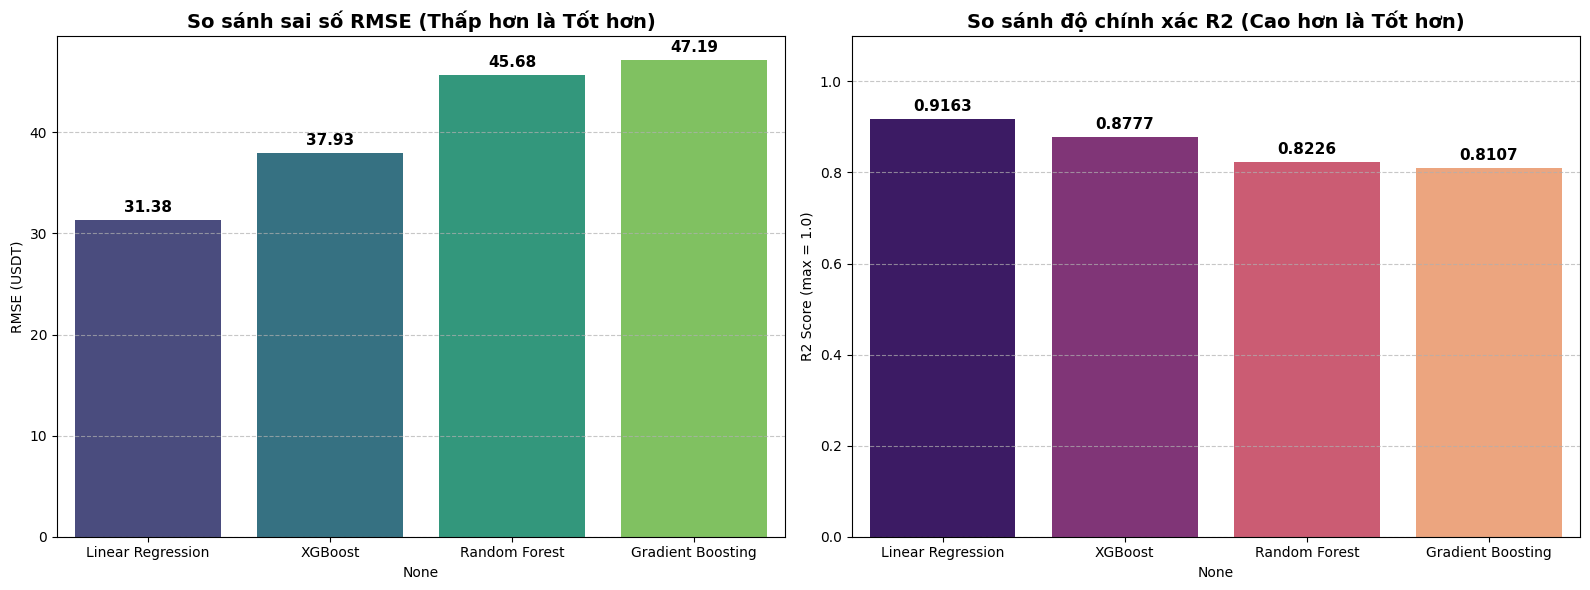

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(16, 6))


sns.barplot(x=results_df.index, y='RMSE', data=results_df, ax=axes[0], palette='viridis')
axes[0].set_title('So sánh sai số RMSE (Thấp hơn là Tốt hơn)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE (USDT)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=11, fontweight='bold')


sns.barplot(x=results_df.index, y='R2', data=results_df, ax=axes[1], palette='magma')
axes[1].set_title('So sánh độ chính xác R2 (Cao hơn là Tốt hơn)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('R2 Score (max = 1.0)')
axes[1].set_ylim(0, 1.1) 
axes[1].grid(axis='y', linestyle='--', alpha=0.7)


for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.4f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Nhận xét và Đánh giá Kết quả (Results Analysis)

Dựa trên bảng tổng hợp hiệu suất các mô hình, ta có những nhận định sau:

### Kết quả chi tiết:
* **Linear Regression:** Đạt hiệu suất tốt nhất với **RMSE thấp nhất (~31.38)** và **R² cao nhất (~0.916)**.
* **XGBoost:** Đứng thứ hai với RMSE ~37.93 và R² ~0.878.
* **Random Forest & Gradient Boosting:** Có hiệu suất thấp hơn đáng kể với sai số lớn hơn (RMSE > 45).

### Phân tích nguyên nhân:
1.  **Tại sao Linear Regression lại tốt nhất?**
    * Trong các khung thời gian ngắn hạn (1 giờ), giá của Bitcoin thường tuân theo tính chất "Martingale" hoặc xu hướng tuyến tính mạnh (giá giờ sau rất gần với giá giờ trước).
    * Biến quan trọng nhất có thể là `close_lag1` (giá của giờ trước đó). Mối quan hệ giữa $Price_{t}$ và $Price_{t-1}$ gần như là tuyến tính ($y = x + \epsilon$), do đó Linear Regression mô phỏng cực tốt mà không bị quá khớp (overfitting).

2.  **Về các mô hình phi tuyến tính (Random Forest, XGBoost):**
    * Dù là các mô hình mạnh, nhưng trong trường hợp này chúng có dấu hiệu hoạt động kém hơn mô hình đơn giản.
    * Có thể do dữ liệu có nhiều nhiễu (noise) khiến các mô hình cây cố gắng học các mẫu phức tạp không tồn tại (Overfitting nhẹ), dẫn đến khả năng tổng quát hóa trên tập Test kém hơn Linear Regression.

### Kết luận:
Đối với bài toán dự báo ngắn hạn (Next Hour) trên bộ dữ liệu này, **Linear Regression** là mô hình phù hợp nhất nhờ sự đơn giản và khả năng nắm bắt xu hướng của giá. Tuy nhiên, **XGBoost** cũng là một ứng viên tiềm năng nếu được tinh chỉnh tham số (Hyperparameter Tuning) kỹ hơn.

Mô hình tốt nhất là: Linear Regression với RMSE = 31.38


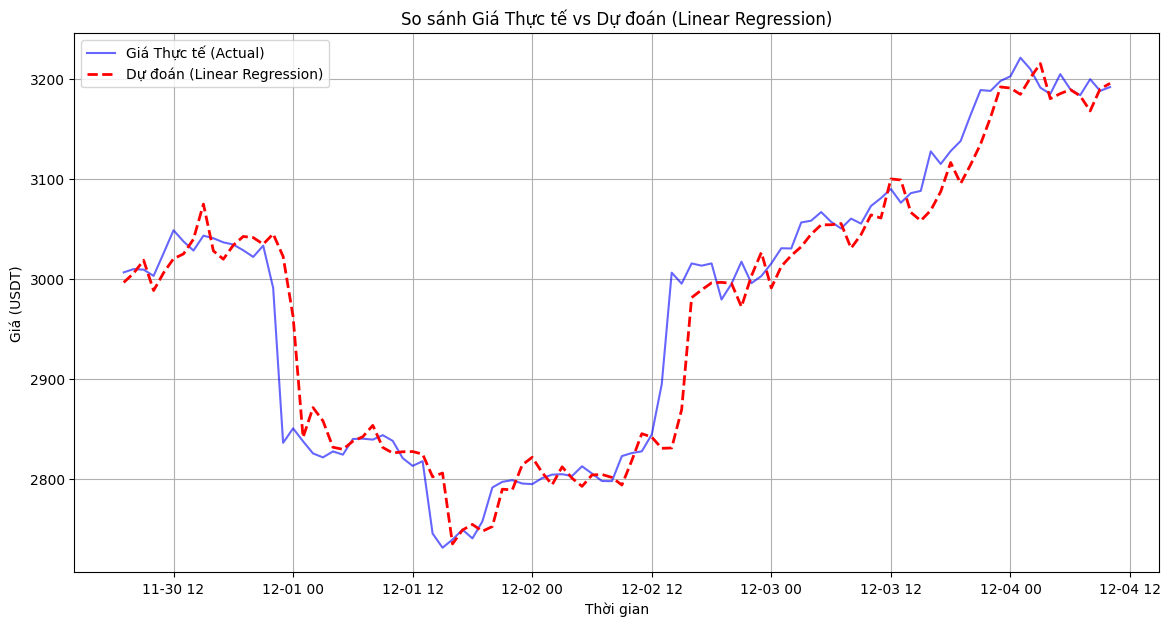

In [ ]:


best_model_name = results_df.index[0] 
best_rmse = results_df.iloc[0]['RMSE']

print(f"Mô hình tốt nhất là: {best_model_name} với RMSE = {best_rmse:.2f}")

y_pred_best = results[best_model_name]["Prediction"]

plot_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_best
}, index=y_test.index)

subset = plot_df.tail(100) 

plt.figure(figsize=(14, 7))
plt.plot(subset.index, subset['Actual'], label='Giá Thực tế (Actual)', color='blue', alpha=0.6)
plt.plot(subset.index, subset['Predicted'], label=f'Dự đoán ({best_model_name})', color='red', linestyle='--', linewidth=2)

plt.title(f'So sánh Giá Thực tế vs Dự đoán ({best_model_name})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.grid(True)
plt.show()

## 4. Phân tích trực quan kết quả dự báo (Visual Analysis)

Biểu đồ dưới đây thể hiện sự so sánh giữa **Giá Thực tế (Xanh)** và **Giá Dự đoán bởi Linear Regression (Đỏ)** trên tập dữ liệu kiểm thử (Test set):

**Quan sát:**
1.  **Độ bám sát xu hướng (Trend Following):**
    * Đường dự đoán (màu đỏ) bám rất sát đường giá thực tế (màu xanh). Mô hình nắm bắt tốt các xu hướng tăng/giảm chính của thị trường.
    * Ở những đoạn thị trường đi ngang (sideway) hoặc biến động nhẹ, mô hình cho kết quả gần như trùng khớp.

2.  **Hiện tượng trễ (Lagging):**
    * Có thể quan sát thấy một độ trễ nhỏ (lag) giữa dự đoán và thực tế. Khi giá thực tế (Xanh) tăng vọt, giá dự đoán (Đỏ) cũng tăng theo nhưng chậm hơn 1 nhịp (1 giờ).
    * **Nguyên nhân:** Do đặc trưng đầu vào quan trọng nhất của mô hình là `close_lag1` (giá của giờ trước đó). Mô hình có xu hướng dự đoán giá giờ tới $P_{t+1}$ sẽ xấp xỉ giá giờ hiện tại $P_t$. Đây là đặc điểm thường thấy ở các mô hình hồi quy chuỗi thời gian cơ bản.

3.  **Khả năng chịu lỗi:**
    * Mặc dù có độ trễ, nhưng biên độ lỗi (khoảng cách giữa hai đường) duy trì ở mức thấp (RMSE ~31.38 USDT). Với mức giá Bitcoin khoảng 3000 USDT (như trong hình), sai số này tương đương khoảng **1%**, là một tỷ lệ chấp nhận được cho bài toán dự báo cơ bản.

## 5. Kết luận chung
Mô hình **Linear Regression** là lựa chọn phù hợp nhất cho bộ dữ liệu hiện tại nhờ sự đơn giản, tốc độ huấn luyện nhanh và độ chính xác cao. Tuy nhiên, để cải thiện "độ trễ" (lag) và bắt đỉnh/đáy tốt hơn trong tương lai, cần xem xét thêm các đặc trưng nâng cao (như Sentiment Analysis, Order Book data) hoặc sử dụng các mô hình chuyên sâu về chuỗi thời gian như LSTM/GRU.